In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score
from scipy import stats
import lightgbm as lgb
import warnings
import os.path
import info
#import lightgbm as lgb
from utils import *

warnings.filterwarnings("ignore")

today = datetime.today()
print("Today's date:", today.strftime("%Y-%m-%d"))


#path of dataset
path_pc = 'C:/Users/admin/Desktop/AI Plan/Finance with AI/Notebooks/'

Today's date: 2020-07-18


In [4]:
outcomes_new_features = load_csv(path_pc, 'outcomes_new_features_2020-04-17.csv')

In [5]:
(len(outcomes_new_features.loc[outcomes_new_features.label_v2 == 1]), 
len(outcomes_new_features.loc[outcomes_new_features.label_v2 == 0]),
len(outcomes_new_features.loc[outcomes_new_features.label_v2 == -1]))

(62259, 87982, 56012)

In [6]:
outcomes_new_features = outcomes_new_features.drop(['log_return_10', 'return_10',
                                                      'log_return_5', 'return_5',
                                                      'log_return_4', 'return_4',
                                                      'log_return_3', 'return_3',
                                                      'log_return_2', 'return_2',
                                                      'log_return_1', 'return_1'
                                                     ], axis=1)

In [7]:
features = info.features_lgb_v2

In [8]:
outcomes_new_dropna = outcomes_new_features.dropna()

features_selected = features

test_size = 100
valid_size = 400
training_size = 2000
valid_test_gap = 4
#label = 'label'
label = 'label_v2'

#make a list of test dates according to test period, by back counting from the latest date with target
test_date = outcomes_new_dropna.index.get_level_values('date')[-1]

print('Test date: ', test_date)

#get all trading dates from dataset of this symbol
data_dates = sorted(list(set(outcomes_new_dropna.index.get_level_values(0))))
data_converted_dates = []
for ts in data_dates:
    data_converted_dates.append(ts.to_pydatetime())

#Calculate training start date and valid start date by back counting
start_date = data_converted_dates[data_converted_dates.index(test_date)-(valid_size + training_size + valid_test_gap + test_size)]
start_date_valid = data_converted_dates[data_converted_dates.index(test_date)-(valid_size + valid_test_gap + test_size)]
end_date_valid = data_converted_dates[data_converted_dates.index(test_date)-valid_test_gap-test_size]
start_date_test = data_converted_dates[data_converted_dates.index(test_date)-test_size]
end_date_test = test_date

print('start_date = ', start_date)
print('start_date_valid = ', start_date_valid)
print('end_date_valid = ', end_date_valid)
print('start_date_test = ', start_date_test)
print('test_date = ', test_date)

X_y_train, X_y_valid, X_y_test = train_valid_test_split(outcomes_new_dropna, start_date,
                                                            start_date_valid, end_date_valid, start_date_test, end_date_test)
#downsample the training set so each class has same number of samples
X_y_train_resampled = downsample_3class(X_y_train, label, 42)
X_y_valid_resampled = downsample_3class(X_y_valid, label, 42)
X_y_test_resampled = downsample_3class(X_y_test, label, 42)

#rename all -1 labels to 2 as LGB only takes 0,1,2...
X_y_train_resampled.loc[X_y_train_resampled[label] == -1, label] = 2
X_y_valid_resampled.loc[X_y_valid_resampled[label] == -1, label] = 2
X_y_test_resampled.loc[X_y_test_resampled[label] == -1, label] = 2

#split into features and target sets
X_train, y_train = feature_target_split(X_y_train_resampled, features_selected, label)
X_valid, y_valid = feature_target_split(X_y_valid_resampled, features_selected, label)
X_test, y_test = feature_target_split(X_y_test_resampled, features_selected, label)

Test date:  2020-04-16 00:00:00
start_date =  2009-11-30 00:00:00
start_date_valid =  2018-03-28 00:00:00
end_date_valid =  2019-11-13 00:00:00
start_date_test =  2019-11-19 00:00:00
test_date =  2020-04-16 00:00:00


In [9]:
len(features_selected)

78

In [13]:
num_tries = 70

cached = []

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)
max_acc = float("-inf")
boosting = 'gbdt'

for i in range(num_tries):
    max_depth = np.random.randint(2,15)
    num_leaves = np.random.randint(8,90)
    exp = np.random.uniform(0.5,3)
    learning_rate = 10**-exp
    min_data = np.random.randint(7,20)
    print('Try no. {} with Max Depth = {} Num Leaves = {} Min data = {} Learning Rate = {}'.format(i, 
                    max_depth, num_leaves, min_data, learning_rate))
    parameters = {
        'application': 'multiclass',
        'num_class': 3,
        #'is_unbalance': 'false',
        #'metric': 'auc',
        #'scale_pos_weight': 9,
        'boosting': boosting,
        'num_leaves': num_leaves,
        'feature_fraction': 0.95,
        'bagging_fraction': 0.2,
        'bagging_freq': 10,
        'learning_rate': learning_rate,
        'verbose': 0,
        'min_data_in_leaf': min_data,
        'max_depth': max_depth
    }
    model = lgb.train(parameters,
                           train_data,
                           valid_sets=valid_data,
                           num_boost_round=5000,
                            verbose_eval=False,
                           #feval=lgb_f1_score,
                           early_stopping_rounds=100)
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_class_pred = [pred.argmax() for pred in y_pred]
    accuracy = accuracy_score(y_valid, y_class_pred)
    print('Accuracy = ', accuracy)
    if accuracy>max_acc:
        max_acc = accuracy
        max_max_depth = max_depth
        max_num_leaves = num_leaves
        max_min_data = min_data
        max_learning_rate = learning_rate

Try no. 0 with Max Depth = 14 Num Leaves = 74 Min data = 10 Learning Rate = 0.006032328100560234
Accuracy =  0.38826959355170637
Try no. 1 with Max Depth = 5 Num Leaves = 76 Min data = 8 Learning Rate = 0.0015636390756564058
Accuracy =  0.3825530212084834
Try no. 2 with Max Depth = 7 Num Leaves = 21 Min data = 9 Learning Rate = 0.013001296357199186
Accuracy =  0.3838678328474247
Try no. 3 with Max Depth = 2 Num Leaves = 53 Min data = 13 Learning Rate = 0.06815050359855691
Accuracy =  0.3759217972903447
Try no. 4 with Max Depth = 12 Num Leaves = 22 Min data = 11 Learning Rate = 0.016966968831705755
Accuracy =  0.38398216429428916
Try no. 5 with Max Depth = 4 Num Leaves = 43 Min data = 18 Learning Rate = 0.0018963109412444793
Accuracy =  0.3838678328474247
Try no. 6 with Max Depth = 9 Num Leaves = 14 Min data = 7 Learning Rate = 0.03893669220027717
Accuracy =  0.37655062024809927
Try no. 7 with Max Depth = 8 Num Leaves = 82 Min data = 9 Learning Rate = 0.001660625714568871
Accuracy =  0.

Accuracy =  0.37923740924941407
Try no. 65 with Max Depth = 3 Num Leaves = 8 Min data = 16 Learning Rate = 0.0029325900769827406
Accuracy =  0.38415366146458585
Try no. 66 with Max Depth = 6 Num Leaves = 61 Min data = 7 Learning Rate = 0.03779492474502136
Accuracy =  0.373006345395301
Try no. 67 with Max Depth = 10 Num Leaves = 15 Min data = 15 Learning Rate = 0.0014086754434441409
Accuracy =  0.3848396501457726
Try no. 68 with Max Depth = 14 Num Leaves = 42 Min data = 18 Learning Rate = 0.05749370571159987
Accuracy =  0.3741496598639456
Try no. 69 with Max Depth = 11 Num Leaves = 25 Min data = 11 Learning Rate = 0.007516562497689093
Accuracy =  0.38518264448636597


In [17]:
print('Max accuracy at {} with Max Depth = {} Num Leaves = {} Min data = {} Learning Rate = {}'.format(max_acc, 
                                                            max_max_depth, max_num_leaves, max_min_data, max_learning_rate))

Max accuracy at 0.39101354827645346 with Max Depth = 7 Num Leaves = 47 Min data = 16 Learning Rate = 0.006985117638031729


In [23]:
# max_depth = max_max_depth
# num_leaves = max_num_leaves
# #learning_rate = 0.0001 #max_learning_rate
# learning_rate = max_learning_rate
# min_data = max_min_data

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

max_depth = 7
num_leaves = 47
#learning_rate = 0.0001 #max_learning_rate
learning_rate = 0.006985117638031729
min_data = 16
boosting = 'gbdt'

print('Training with Max Depth = {} Num Leaves = {} Min data = {} Learning Rate = {}'.format(max_depth, num_leaves, min_data, learning_rate))
parameters = {
    'application': 'multiclass',
    'num_class': 3,
    #'is_unbalance': 'false',
    #'metric': 'auc',
    #'scale_pos_weight': 9,
    'boosting': boosting,
    'num_leaves': num_leaves,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.2,
    'bagging_freq': 10,
    'learning_rate': learning_rate,
    'verbose': 0,
    'min_data_in_leaf': min_data,
    'max_depth': max_depth
}
model = lgb.train(parameters,
                       train_data,
                       valid_sets=valid_data,
                       num_boost_round=500,
                        verbose_eval=False,
                       #feval=lgb_f1_score,
                       early_stopping_rounds=100)

y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
y_class_pred = [pred.argmax() for pred in y_pred]
accuracy = accuracy_score(y_valid, y_class_pred)
print('Accuracy = ', accuracy)

Training with Max Depth = 7 Num Leaves = 47 Min data = 16 Learning Rate = 0.006985117638031729
Accuracy =  0.39101354827645346


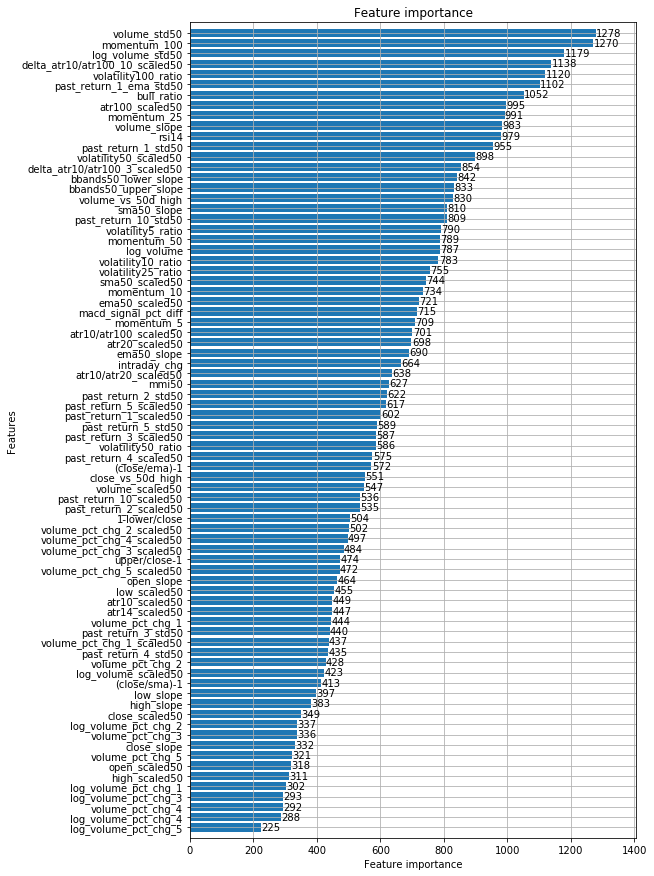

In [12]:
lgb.plot_importance(model, figsize = (8,15), height = 0.8)

In [10]:
X_y_sets = [('Training',X_train,y_train),('Validation',X_valid,y_valid),('Test',X_test,y_test)]
             
for (name, X_set, y_set) in X_y_sets:
    y_pred = model.predict(X_set, num_iteration=model.best_iteration)
    y_class_pred = [pred.argmax() for pred in y_pred]
    accuracy = accuracy_score(y_set, y_class_pred)
    print(name+' accuracy = ', accuracy)

Training accuracy =  0.49900130598448184
Validation accuracy =  0.39101354827645346
Test accuracy =  0.40004522840343737


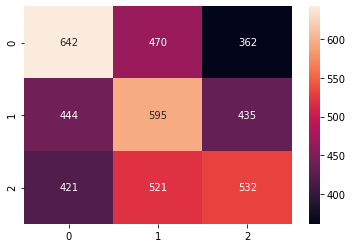

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_class_pred), annot=True, fmt="d")

In [12]:
X_test['pred'] = y_class_pred
X_test['label_v2'] = y_test

In [27]:
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_train_class_pred = [pred.argmax() for pred in y_train_pred]

X_train['pred'] = y_train_class_pred
X_train['label_v2'] = y_train

In [28]:
TP_1 = len(X_train.loc[(X_train['pred']==1) & (X_train['label_v2']==1)])
FP_1 = len(X_train.loc[(X_train['pred']==1) & (X_train['label_v2']!=1)])
TP_2 = len(X_train.loc[(X_train['pred']==2) & (X_train['label_v2']==2)])
FP_2 = len(X_train.loc[(X_train['pred']==2) & (X_train['label_v2']!=2)])
TP_0 = len(X_train.loc[(X_train['pred']==0) & (X_train['label_v2']==0)])
FP_0 = len(X_train.loc[(X_train['pred']==0) & (X_train['label_v2']!=0)])

print('Precision for 0 = ', TP_0/(TP_0+FP_0))
print('Precision for 1 = ', TP_1/(TP_1+FP_1))
print('Precision for 2 = ', TP_2/(TP_2+FP_2))

Precision for 0 =  0.47036802030456853
Precision for 1 =  0.5211627177856407
Precision for 2 =  0.5158111729540301


In [33]:
len(X_train), len(X_train.loc[(X_train['pred']==0) & (X_train['label_v2']==0)]), len(X_train.loc[(X_train['pred']==1) & (X_train['label_v2']==1)]), len(X_train.loc[(X_train['pred']==2) & (X_train['label_v2']==2)]) 

(78102, 14826, 11636, 12511)

In [24]:
TP_1 = len(X_test.loc[(X_test['pred']==1) & (X_test['label_v2']==1)])
FP_1 = len(X_test.loc[(X_test['pred']==1) & (X_test['label_v2']!=1)])
TP_2 = len(X_test.loc[(X_test['pred']==2) & (X_test['label_v2']==2)])
FP_2 = len(X_test.loc[(X_test['pred']==2) & (X_test['label_v2']!=2)])
TP_0 = len(X_test.loc[(X_test['pred']==0) & (X_test['label_v2']==0)])
FP_0 = len(X_test.loc[(X_test['pred']==0) & (X_test['label_v2']!=0)])

print('Precision for 0 = ', TP_0/(TP_0+FP_0))
print('Precision for 1 = ', TP_1/(TP_1+FP_1))
print('Precision for 2 = ', TP_2/(TP_2+FP_2))

Precision for 0 =  0.42601194426011946
Precision for 1 =  0.3751576292559899
Precision for 2 =  0.400300978179082


In [19]:
df_false_postive_1 = X_test.loc[(X_test['pred']==1) & (X_test['label_v2']!=1)]
df_false_postive_2 = X_test.loc[(X_test['pred']==2) & (X_test['label_v2']!=2)]
df_true_postive_1 = X_test.loc[(X_test['pred']==1) & (X_test['label_v2']==1)]
df_true_postive_2 = X_test.loc[(X_test['pred']==2) & (X_test['label_v2']==2)]

In [22]:
df_false_postive_1[['momentum_100','momentum_50','momentum_10','momentum_5','pred','label_v2']]

momentum_100  momentum_50  momentum_10    momentum_5  \
date       symbol                                                          
2019-11-20 0003.HK    -29.301627    -4.386615   -23.593594  1.633006e+02   
           0066.HK    -34.870397    -5.006087   -25.217245  5.986977e+02   
           0083.HK     -6.842021    -0.015044   -33.866522  1.295960e+03   
           0857.HK     -3.367353   -30.982416   -71.334754  4.752873e-09   
           0941.HK    -12.105635   -16.338023   -35.123879  1.840716e+02   
...                          ...          ...          ...           ...   
2020-04-07 0019.HK    -23.283381   -66.858900    -0.013775  2.135535e+03   
           0175.HK    -28.930312   -33.260217   -35.890501  2.915660e+03   
           1997.HK    -42.015099   -78.253594   -60.072574 -2.736819e+01   
2020-04-08 0019.HK    -25.268564   -68.722292     0.643298  8.986615e+02   
           2018.HK    -30.792039   -73.888510    44.367606  8.586425e+03   

                    pred  label_v2  
date       symbol                   
2019-11-20 0003.HK     1       0.0  
           0066.HK     1       0.0  
           0083.HK     1       0.0  
           0857.HK     1       0.0  
           0941.HK     1       2.0  
...                  ...       ...  
2020-04-07 0019.HK     1       0.0  
           0175.HK     1       0.0  
           1997.HK     1       0.0  
2020-04-08 0019.HK     1       0.0  
           2018.HK     1       2.0  

[991 rows x 6 columns]

In [23]:
df_true_postive_1[['momentum_100','momentum_50','momentum_10','momentum_5','pred','label_v2']]

momentum_100  momentum_50  momentum_10    momentum_5  \
date       symbol                                                          
2019-11-21 0005.HK     -4.921421    -0.894609   -18.009112  2.069316e+00   
           0066.HK    -34.558463    -5.054670    -6.979347  4.704376e+01   
           0700.HK    -14.166949    -5.064370    21.504851  1.919115e+02   
           0857.HK     -3.440408   -32.320562   -63.551783 -8.223062e+00   
2019-11-22 0941.HK    -12.004419   -18.138403   -12.024892 -1.609931e+01   
...                          ...          ...          ...           ...   
2020-04-08 1928.HK    -24.746228   -73.636651   -18.484936  5.755288e+02   
           1997.HK    -44.213899   -78.545341   -56.713318 -2.160443e+00   
2020-04-09 1997.HK    -46.491798   -79.414543   -37.053300  7.450457e+02   
2020-04-15 1997.HK    -50.312566   -80.728256    -9.249481  1.400310e+02   
2020-04-16 1997.HK    -51.661564   -81.321664    -0.083688 -6.946832e-08   

                    pred  label_v2  
date       symbol                   
2019-11-21 0005.HK     1       1.0  
           0066.HK     1       1.0  
           0700.HK     1       1.0  
           0857.HK     1       1.0  
2019-11-22 0941.HK     1       1.0  
...                  ...       ...  
2020-04-08 1928.HK     1       1.0  
           1997.HK     1       1.0  
2020-04-09 1997.HK     1       1.0  
2020-04-15 1997.HK     1       1.0  
2020-04-16 1997.HK     1       1.0  

[595 rows x 6 columns]

In [28]:
df_true = X_test.loc[X_test['label_v2']==1]

In [29]:
df_pred_plus = X_test.loc[(X_test['pred']==1) 
                         & (X_test['momentum_5']>0)
                         & (X_test['close_scaled50']>1.5)
                         & (X_test['volume_scaled50']>0.5)
                         #& (X_test['rsi14']>50)
                         #& (X_test['close_vs_50d_high']>0.8)
                         & (X_test['macd_signal_pct_diff']<0.7)
                        ]
df_pred_minus = X_test.loc[(X_test['pred']==2) & (X_test['momentum_5']<-60)
                         #& (X_test['momentum_100']<-40)
                         & (X_test['close_scaled50']<1.5)
                         & (X_test['volume_scaled50']>1)
                         #& (X_test['rsi14']<40)
                         & (X_test['bull_ratio']<0)
                        ]

In [30]:
TP_new = len(df_pred_plus.loc[df_pred_plus['label_v2']==1])
FP_new = len(df_pred_plus.loc[df_pred_plus['label_v2']!=1])

print('Number of new predictions for +1 = ', len(df_pred_plus))
print('Number of correct new predictions = ', len(df_pred_plus.loc[df_pred_plus['label_v2']==1]))
print('New precision for 1 = ', TP_new/(TP_new+FP_new))

TP_new_2 = len(df_pred_minus.loc[df_pred_minus['label_v2']==2])
FP_new_2 = len(df_pred_minus.loc[df_pred_minus['label_v2']!=2])

print()
print('Number of new predictions for -1 = ', len(df_pred_minus))
print('Number of correct new predictions = ', len(df_pred_minus.loc[df_pred_minus['label_v2']==2]))
print('New precision for 1 = ', TP_new_2/(TP_new_2+FP_new_2))


Number of new predictions for +1 =  56
Number of correct new predictions =  15
New precision for 1 =  0.26785714285714285

Number of new predictions for -1 =  78
Number of correct new predictions =  42
New precision for 1 =  0.5384615384615384


In [31]:
X_test['rsi14']

date        symbol 
2019-11-20  0001.HK    52.341533
            0002.HK    45.307618
            0003.HK    45.707851
            0005.HK    42.920306
            0006.HK    55.487999
                         ...    
2020-04-15  1044.HK    62.128360
            1928.HK    48.212113
            1997.HK    38.217675
2020-04-16  1928.HK    50.055235
            1997.HK    36.062532
Name: rsi14, Length: 4422, dtype: float64

In [32]:
df_pred_plus

delta_atr10/atr100_3_scaled50  \
date       symbol                                   
2019-11-26 0151.HK                      -0.233319   
2019-11-28 2382.HK                       0.149430   
2019-12-03 0688.HK                       1.910565   
2019-12-06 0151.HK                      -0.270195   
           2382.HK                       1.869852   
2019-12-11 0066.HK                       0.601153   
           0151.HK                      -1.857852   
2019-12-12 0066.HK                       1.093905   
2019-12-13 0066.HK                       1.207766   
           0388.HK                       1.401577   
           2007.HK                      -0.619180   
2019-12-17 0151.HK                       0.477069   
           0388.HK                       1.192597   
           2007.HK                       0.387498   
           3328.HK                       2.332913   
2019-12-18 0883.HK                       2.401724   
           3328.HK                       0.768569   
           3988.HK                      -0.356211   
2019-12-20 0388.HK                      -0.538353   
2020-01-02 0027.HK                       0.382691   
           0388.HK                       1.768128   
           2007.HK                       0.773138   
2020-01-03 0388.HK                       3.101314   
           0883.HK                       0.987281   
           1398.HK                       1.550791   
           2007.HK                       1.449795   
2020-01-06 0386.HK                       2.242529   
           0388.HK                       2.820760   
           0883.HK                       2.518287   
           2628.HK                       3.047775   
2020-01-07 0175.HK                       2.545791   
           0883.HK                       2.281233   
           2628.HK                       2.734391   
2020-01-08 0386.HK                       0.813608   
2020-01-09 0175.HK                       0.958007   
           0883.HK                       0.960370   
           1044.HK                       3.039001   
2020-01-10 1044.HK                       2.396552   
2020-01-13 0016.HK                       1.296710   
           0066.HK                       0.853395   
           0939.HK                       0.483266   
           1038.HK                       0.910838   
           2318.HK                       1.007802   
2020-01-14 0027.HK                      -0.042411   
           1113.HK                       0.376881   
           2318.HK                       1.907534   
2020-01-15 2318.HK                       2.755950   
2020-01-16 0669.HK                       0.013350   
2020-01-17 0003.HK                       2.414770   
           2318.HK                       3.492363   
           2388.HK                       0.583238   
2020-01-20 0941.HK                       3.891287   
           2318.HK                       3.065601   
2020-01-21 0941.HK                       3.673300   
2020-02-06 1044.HK                       0.743374   
2020-02-10 1044.HK                       0.588716   

                    delta_atr10/atr100_10_scaled50  atr10_scaled50  \
date       symbol                                                    
2019-11-26 0151.HK                        1.778382        2.474872   
2019-11-28 2382.HK                       -0.205631        0.177149   
2019-12-03 0688.HK                        0.805837        1.760141   
2019-12-06 0151.HK                       -1.041465        1.059226   
           2382.HK                        1.123741        2.076864   
2019-12-11 0066.HK                       -0.462773       -0.255991   
           0151.HK                       -1.881033        0.129293   
2019-12-12 0066.HK                       -0.335229       -0.346064   
2019-12-13 0066.HK                       -0.495929       -0.324893   
           0388.HK                       -0.564660       -0.318055   
           2007.HK                       -0.629677        0.192101   
2019-12-17 0151.HK                 

In [30]:
df_pred_minus

delta_atr10/atr100_3_scaled50  \
date       symbol                                   
2019-11-11 1044.HK                       0.366524   
2019-11-13 0019.HK                       3.306640   
2019-11-14 0019.HK                       0.567178   
2019-11-15 1997.HK                       0.524259   
2020-01-21 1088.HK                       0.961050   
...                                           ...   
2020-03-18 2007.HK                       2.852500   
           3328.HK                       1.126651   
2020-03-19 0002.HK                       2.499531   
           0016.HK                       1.126304   
           0939.HK                       0.477386   

                    delta_atr10/atr100_10_scaled50  atr10_scaled50  \
date       symbol                                                    
2019-11-11 1044.HK                        0.547180       -0.070831   
2019-11-13 0019.HK                        2.130799        0.651077   
2019-11-14 0019.HK                        1.717462        0.517489   
2019-11-15 1997.HK                        1.288385       -0.116550   
2020-01-21 1088.HK                        1.156280        0.496052   
...                                            ...             ...   
2020-03-18 2007.HK                        3.516015        4.079868   
           3328.HK                        3.652674        3.784005   
2020-03-19 0002.HK                        2.904586        3.752031   
           0016.HK                        2.518226        3.358190   
           0939.HK                        2.101444        2.813157   

                    atr14_scaled50  atr20_scaled50  atr100_scaled50  \
date       symbol                                                     
2019-11-11 1044.HK       -0.354982       -0.621934        -1.383464   
2019-11-13 0019.HK        0.129420       -0.277624        -0.899038   
2019-11-14 0019.HK        0.063443       -0.317522        -0.932344   
2019-11-15 1997.HK       -0.395156       -0.644254        -1.178757   
2020-01-21 1088.HK        0.193330       -0.179695        -1.292008   
...                            ...             ...              ...   
2020-03-18 2007.HK        4.085146        4.046897         4.309626   
           3328.HK        3.870873        3.927721         3.880027   
2020-03-19 0002.HK        3.797211        3.853814         3.889041   
           0016.HK        3.423897        3.511110         3.490068   
           0939.HK        2.755807        2.690127         2.673690   

                    atr10/atr100_scaled50  atr10/atr20_scaled50     mmi50  \
date       symbol                                                           
2019-11-11 1044.HK               0.557303              1.021797  0.571429   
2019-11-13 0019.HK               1.048069              2.545853  0.653061   
2019-11-14 0019.HK               0.889484              2.118594  0.632653   
2019-11-15 1997.HK               0.088596              0.861776  0.632653   
2020-01-21 1088.HK               1.396493              1.539862  0.612245   
...                                   ...                   ...       ...   
2020-03-18 2007.HK               3.922963              3.525574  0.571429   
           3328.HK               3.654811              3.199580  0.612245   
2020-03-19 0002.HK               3.485742              2.861033  0.693878   
           0016.HK               3.175017              2.585042  0.632653   
           0939.HK               2.580514              2.106701  0.571429   

                    past_return_5_std50  ...  volume_pct_chg_4_scaled50  \
date       symbol                        ...                              
2019-11-11 1044.HK             0.030972  ...                  -0.709889   
2019-11-13 0019.HK             0.030505  ...                  -0.854914   
2019-11-14 0019.HK             0.033797  ...                  -0.961045   
2019-11-15 1997.HK             0.043027  ...                   0.099034   
2020-01-21 1088.HK             0.029583  ..

In [31]:
for i, row in X_test.iterrows():
    print(i[1])

0001.HK
0003.HK
0005.HK
0006.HK
0011.HK
0012.HK
0016.HK
0019.HK
0027.HK
0066.HK
0083.HK
0175.HK
0267.HK
0386.HK
0388.HK
0669.HK
0700.HK
0823.HK
0857.HK
0883.HK
0939.HK
1038.HK
1044.HK
1088.HK
1093.HK
1109.HK
1113.HK
1177.HK
1299.HK
1928.HK
1997.HK
2018.HK
2313.HK
2319.HK
2382.HK
2388.HK
2628.HK
3328.HK
3988.HK
0001.HK
0002.HK
0003.HK
0005.HK
0006.HK
0011.HK
0012.HK
0017.HK
0019.HK
0027.HK
0066.HK
0083.HK
0101.HK
0151.HK
0175.HK
0267.HK
0288.HK
0386.HK
0388.HK
0669.HK
0688.HK
0700.HK
0762.HK
0823.HK
0857.HK
0939.HK
0941.HK
1038.HK
1044.HK
1088.HK
1093.HK
1113.HK
1299.HK
1398.HK
1928.HK
1997.HK
2007.HK
2018.HK
2313.HK
2318.HK
2319.HK
2382.HK
2388.HK
2628.HK
3328.HK
3988.HK
0001.HK
0002.HK
0003.HK
0006.HK
0011.HK
0012.HK
0016.HK
0017.HK
0019.HK
0066.HK
0101.HK
0151.HK
0175.HK
0288.HK
0386.HK
0388.HK
0669.HK
0688.HK
0762.HK
0823.HK
0883.HK
0939.HK
0941.HK
1038.HK
1044.HK
1088.HK
1093.HK
1109.HK
1177.HK
1299.HK
1398.HK
1928.HK
1997.HK
2007.HK
2018.HK
2313.HK
2318.HK
2319.HK
2382.HK
2388.HK


2313.HK
2318.HK
2319.HK
2382.HK
2388.HK
2628.HK
3328.HK
3988.HK
0001.HK
0001.HK
0002.HK
0003.HK
0005.HK
0006.HK
0011.HK
0012.HK
0016.HK
0017.HK
0019.HK
0027.HK
0066.HK
0066.HK
0083.HK
0101.HK
0151.HK
0175.HK
0267.HK
0288.HK
0386.HK
0388.HK
0669.HK
0688.HK
0700.HK
0762.HK
0823.HK
0857.HK
0883.HK
0939.HK
0941.HK
1038.HK
1044.HK
1088.HK
1093.HK
1109.HK
1113.HK
1177.HK
1299.HK
1398.HK
1928.HK
2007.HK
2018.HK
2313.HK
2318.HK
2319.HK
2382.HK
2388.HK
2628.HK
3328.HK
3988.HK
0001.HK
0001.HK
0002.HK
0003.HK
0005.HK
0006.HK
0011.HK
0012.HK
0016.HK
0017.HK
0019.HK
0027.HK
0066.HK
0083.HK
0101.HK
0151.HK
0175.HK
0267.HK
0288.HK
0386.HK
0388.HK
0669.HK
0688.HK
0700.HK
0762.HK
0823.HK
0857.HK
0883.HK
0939.HK
0941.HK
1038.HK
1044.HK
1088.HK
1093.HK
1109.HK
1113.HK
1299.HK
1398.HK
1928.HK
1997.HK
2007.HK
2007.HK
2018.HK
2313.HK
2319.HK
2382.HK
2388.HK
2628.HK
3328.HK
3988.HK
0001.HK
0001.HK
0002.HK
0003.HK
0005.HK
0006.HK
0011.HK
0012.HK
0016.HK
0017.HK
0019.HK
0027.HK
0066.HK
0083.HK
0101.HK
0151.HK


In [32]:
X_test.loc[(X_test.index.get_level_values('date')=='2020-02-28') & (X_test['pred']==2)]

delta_atr10/atr100_3_scaled50  \
date       symbol                                   
2020-02-28 0001.HK                       1.024015   
           0003.HK                      -0.021357   
           0003.HK                      -0.021357   
           0005.HK                       1.508529   
           0006.HK                       1.015806   
           0016.HK                       2.363559   
           0017.HK                       1.565067   
           0019.HK                       0.036649   
           0027.HK                      -0.579420   
           0083.HK                      -0.102491   
           0151.HK                      -0.313408   
           0386.HK                       0.974026   
           0669.HK                       2.157799   
           0700.HK                      -0.025984   
           0762.HK                       0.559401   
           0823.HK                       0.515760   
           0883.HK                       1.032373   
           0883.HK                       1.032373   
           0939.HK                       1.664991   
           0941.HK                       0.969081   
           1038.HK                       1.190989   
           1088.HK                       1.131141   
           1093.HK                       0.091837   
           1177.HK                       0.831902   
           1299.HK                       0.478576   
           1398.HK                       1.890276   
           1398.HK                       1.890276   
           1928.HK                      -0.773444   
           2007.HK                       1.561042   
           2313.HK                       0.316983   
           2318.HK                       0.585974   
           2628.HK                       0.403761   
           3328.HK                       1.343497   
           3988.HK                       1.466488   

                    delta_atr10/atr100_10_scaled50  atr10_scaled50  \
date       symbol                                                    
2020-02-28 0001.HK                       -0.260414       -1.307862   
           0003.HK                       -0.818860       -0.683946   
           0003.HK                       -0.818860       -0.683946   
           0005.HK                        0.936163        1.936184   
           0006.HK                        0.546201        1.299468   
           0016.HK                        0.188132        0.525238   
           0017.HK                        0.545734        0.215545   
           0019.HK                       -0.129956        0.996101   
           0027.HK                       -0.979677       -0.149133   
           0083.HK                        0.528801        1.148590   
           0151.HK                       -0.757818       -0.597296   
           0386.HK                       -0.649085        0.280392   
           0669.HK                        0.356629        2.063603   
           0700.HK                        0.100994        1.018635   
           0762.HK                        0.040980       -0.144225   
           0823.HK                       -0.358915        0.010834   
           0883.HK                       -0.066628        0.518973   
           0883.HK                       -0.066628        0.518973   
           0939.HK                       -0.178789        1.326448   
           0941.HK                       -0.069887        0.791478   
           1038.HK                       -0.752639       -1.695698   
           1088.HK                       -0.740717        0.627757   
           1093.HK                       -0.510246       -0.155565   
           1177.HK                       -0.090936        0.442402   
           1299.HK                       -0.948193       -0.788871   
           1398.HK                       -0.172199        0.931755   
           1398.HK                       -0.172199        0.931755   
           1928.HK                       -1.238436       -0.146702   
           